In [1]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
import torch

In [10]:
def distance(point, rectangle):
    image = np.zeros((100, 100), dtype='uint8')
    (x0, y0) = point
    (x1,y1) = rectangle[:2]
    (x2,y2) = rectangle[2:]
    
    #minimum distance is in some corner point
    if x0>=x2 and y0<=y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<=x1 and y0<=y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<=x1 and y0>=y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>=x2 and y0>=y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]   
    # point is inside rectangle  - distance is the distance between two centers  
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        print(d_coord)     
        
    #draw distance
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(255,0,0), thickness=1)
    cv2.circle(image, (x0,y0), radius=0, color=(255, 0, 0), thickness=-1)
    cv2.line(image, d_coord[:2], d_coord[2:], color = (255, 255, 255), thickness=1)
    plt.imshow(image)
    plt.axis("off")
    return d

[55, 60, 70, 60]
15.0


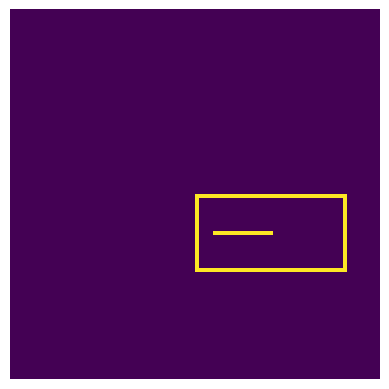

In [11]:
d = distance([55,60], [50, 50, 90, 70])
print(d)

In [12]:
def get_distance(rect1, rect2):
    # take senter of person as a point
    (x0, y0) = int((rect1[0]+rect1[2])/2), int((rect1[1]+rect1[3])/2)
    (x1,y1) = rect2[:2]
    (x2,y2) = rect2[2:]
    
    #d=0
    
    #minimum distance is in some corner point
    if x0>=x2 and y0<=y1:
        d=np.sqrt((x2-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x2,y1]
    if x0<=x1 and y0<=y1:
        d=np.sqrt((x1-x0)**2+(y1-y0)**2)
        d_coord = [x0,y0, x1,y1]  
    if x0<=x1 and y0>=y2:
        d=np.sqrt((x1-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x1,y2]    
    if x0>=x2 and y0>=y2:
        d=np.sqrt((x2-x0)**2+(y2-y0)**2)
        d_coord = [x0,y0, x2,y2]     
     #minimum distance is on the edge: draw perpendicular to that edge from (x0,y0)
    if x0>=x1 and x0<=x2 and y0>=y2:
        d=y0-y2
        d_coord = [x0,y0, x0,y2] 
    if x0>=x1 and x0<=x2 and y0<=y1:
        d=y1-y0
        d_coord = [x0,y0, x0,y1]  
    if y0>=y1 and y0<=y2 and x0>=x2:
        d=x0-x2
        d_coord = [x0,y0, x2,y0] 
    if y0>=y1 and y0<=y2 and x0<=x1:
        d=x1-x0
        d_coord = [x0,y0, x1,y0]      
    if x0>=x1 and x0<=x2 and y0>=y1 and y0<=y2:
        center_x = int((x1+x2)/2)
        center_y = int((y1+y2)/2)
        d=np.sqrt((center_x-x0)**2+(center_y-y0)**2)
        d_coord = [x0,y0, center_x, center_y] 
        
    
    return d

In [13]:
model = YOLO('yolov8n.pt')

In [14]:
cap = cv2.VideoCapture("videos/traffic2.mp4")


while True:
    _, frame = cap.read()
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = model.predict(img)
    people_boxes = []
    cars_boxes = []
    
    for r in results:
        boxes = r.boxes
        for box in boxes: 
            b = box.xyxy[0].numpy().astype("int") # get box coordinates in (top, left, bottom, right) format
            c = box.cls
            if model.names[int(c)]=="person":
                people_boxes.append(b)
            if model.names[int(c)] in ["car", "truck"]:
                cars_boxes.append(b)  
            
                           
            # print(b)
            # print(model.names[int(c)])
            if model.names[int(c)] in ['person', 'car', "truck"]:
                cv2.rectangle(frame, b[:2], b[2:], color = (255, 0, 0), thickness=2)
                
    # print(cars_boxes)            
    # d = get_distance(cars_boxes[0], cars_boxes[1])
    # print(d)
                
    for person in people_boxes:
        for car in cars_boxes:
            if get_distance(person, car)<10:
                print(get_distance(person, car))
                cv2.rectangle(frame, person[:2], person[2:], color = (0, 0, 255), thickness=3) 
                cv2.rectangle(frame, car[:2], car[2:], color = (0, 0, 255), thickness=3)
                cv2.putText(frame, "ALARM!", (20, 50), cv2.FONT_HERSHEY_SIMPLEX , fontScale = 1, color=(0, 0, 255), thickness=5) 
                            
    imS = cv2.resize(frame, (960, 540))        
    cv2.imshow('YOLO V8 Detection', imS)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


0: 384x640 6 persons, 5 cars, 1 truck, 2 traffic lights, 300.7ms
Speed: 15.9ms preprocess, 300.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 5 cars, 1 truck, 1 traffic light, 281.6ms
Speed: 9.8ms preprocess, 281.6ms inference, 23.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 1 traffic light, 263.2ms
Speed: 3.6ms preprocess, 263.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 1 truck, 1 traffic light, 317.4ms
Speed: 5.0ms preprocess, 317.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 2 traffic lights, 397.1ms
Speed: 16.8ms preprocess, 397.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 5 cars, 1 truck, 2 traffic lights, 208.8ms
Speed: 4.0ms preprocess, 208.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 pe

1


0: 384x640 8 persons, 5 cars, 3 traffic lights, 147.8ms
Speed: 3.6ms preprocess, 147.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



5


0: 384x640 8 persons, 5 cars, 3 traffic lights, 165.4ms
Speed: 4.1ms preprocess, 165.4ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 6 cars, 1 truck, 4 traffic lights, 164.3ms
Speed: 2.4ms preprocess, 164.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 6 cars, 1 truck, 3 traffic lights, 160.9ms


6


Speed: 3.7ms preprocess, 160.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



6


0: 384x640 9 persons, 4 cars, 1 truck, 3 traffic lights, 174.7ms
Speed: 3.5ms preprocess, 174.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 1 truck, 3 traffic lights, 172.1ms
Speed: 4.5ms preprocess, 172.1ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 3 traffic lights, 134.2ms
Speed: 3.2ms preprocess, 134.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 cars, 3 traffic lights, 149.7ms
Speed: 13.4ms preprocess, 149.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 3 traffic lights, 138.1ms
Speed: 18.5ms preprocess, 138.1ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)



8
9


0: 384x640 8 persons, 4 cars, 3 traffic lights, 177.1ms
Speed: 1.8ms preprocess, 177.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 1 truck, 5 traffic lights, 122.0ms
Speed: 4.9ms preprocess, 122.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



8
8


0: 384x640 8 persons, 5 cars, 1 truck, 5 traffic lights, 162.0ms
Speed: 2.9ms preprocess, 162.0ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 4 traffic lights, 151.3ms
Speed: 4.9ms preprocess, 151.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 1 truck, 3 traffic lights, 160.8ms
Speed: 3.4ms preprocess, 160.8ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 2 traffic lights, 134.1ms
Speed: 3.7ms preprocess, 134.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 cars, 1 truck, 1 traffic light, 154.4ms
Speed: 7.2ms preprocess, 154.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 1 truck, 2 traffic lights, 169.7ms
Speed: 4.5ms preprocess, 169.7ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 cars, 1 tr

7


0: 384x640 6 persons, 4 cars, 1 truck, 4 traffic lights, 154.2ms
Speed: 4.6ms preprocess, 154.2ms inference, 16.8ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 4 persons, 4 cars, 1 truck, 4 traffic lights, 164.4ms
Speed: 9.0ms preprocess, 164.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 9 persons, 4 cars, 1 truck, 4 traffic lights, 163.6ms
Speed: 4.9ms preprocess, 163.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 5 traffic lights, 153.8ms
Speed: 0.7ms preprocess, 153.8ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 4 traffic lights, 145.2ms


9


Speed: 4.3ms preprocess, 145.2ms inference, 16.7ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 7 persons, 4 cars, 1 truck, 3 traffic lights, 180.5ms
Speed: 4.5ms preprocess, 180.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 2 traffic lights, 136.3ms


8


Speed: 4.2ms preprocess, 136.3ms inference, 14.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 4 cars, 3 traffic lights, 157.6ms


4


Speed: 4.4ms preprocess, 157.6ms inference, 7.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 4 cars, 1 truck, 4 traffic lights, 137.2ms
Speed: 9.6ms preprocess, 137.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



3
3
5


0: 384x640 10 persons, 4 cars, 1 truck, 4 traffic lights, 164.8ms
Speed: 12.1ms preprocess, 164.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 4 traffic lights, 155.5ms


5
6


Speed: 3.1ms preprocess, 155.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 4 traffic lights, 149.9ms


6


Speed: 5.4ms preprocess, 149.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 10 persons, 4 cars, 4 traffic lights, 209.2ms
Speed: 6.2ms preprocess, 209.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



8


0: 384x640 9 persons, 4 cars, 4 traffic lights, 169.9ms
Speed: 2.9ms preprocess, 169.9ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 9 persons, 4 cars, 4 traffic lights, 166.8ms
Speed: 3.4ms preprocess, 166.8ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)



8


0: 384x640 7 persons, 4 cars, 5 traffic lights, 170.5ms
Speed: 4.0ms preprocess, 170.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 5 traffic lights, 146.7ms


7


Speed: 4.6ms preprocess, 146.7ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 bicycle, 5 cars, 3 traffic lights, 151.3ms


6


Speed: 2.5ms preprocess, 151.3ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 10 persons, 1 bicycle, 4 cars, 3 traffic lights, 188.6ms
Speed: 4.3ms preprocess, 188.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 9 persons, 4 cars, 1 truck, 3 traffic lights, 203.6ms
Speed: 5.0ms preprocess, 203.6ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 4 traffic lights, 170.9ms


6


Speed: 4.0ms preprocess, 170.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



8


0: 384x640 10 persons, 4 cars, 3 traffic lights, 178.2ms
Speed: 3.8ms preprocess, 178.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 12 persons, 4 cars, 1 truck, 4 traffic lights, 182.2ms
Speed: 6.0ms preprocess, 182.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 3 traffic lights, 177.4ms
Speed: 3.5ms preprocess, 177.4ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traffic lights, 154.2ms
Speed: 3.6ms preprocess, 154.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 4 traffic lights, 171.5ms
Speed: 2.8ms preprocess, 171.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



6.082762530298219


0: 384x640 10 persons, 4 cars, 4 traffic lights, 160.4ms
Speed: 4.9ms preprocess, 160.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 4 traffic lights, 156.7ms


6


Speed: 16.4ms preprocess, 156.7ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)



5


0: 384x640 10 persons, 4 cars, 3 traffic lights, 194.2ms
Speed: 9.8ms preprocess, 194.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



6


0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 190.6ms
Speed: 3.3ms preprocess, 190.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 146.3ms
Speed: 5.1ms preprocess, 146.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



5
5


0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 178.1ms
Speed: 3.5ms preprocess, 178.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 2 traffic lights, 163.3ms
Speed: 3.6ms preprocess, 163.3ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 2 traffic lights, 120.9ms
Speed: 14.0ms preprocess, 120.9ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)



7.211102550927978
5


0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 140.1ms
Speed: 5.0ms preprocess, 140.1ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 2 traffic lights, 151.8ms


9


Speed: 2.7ms preprocess, 151.8ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 207.0ms
Speed: 4.9ms preprocess, 207.0ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 3 traffic lights, 121.6ms
Speed: 4.0ms preprocess, 121.6ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)



7
8


0: 384x640 11 persons, 4 cars, 2 traffic lights, 150.5ms
Speed: 4.1ms preprocess, 150.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 2 traffic lights, 134.8ms
Speed: 1.8ms preprocess, 134.8ms inference, 13.2ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 12 persons, 4 cars, 2 traffic lights, 171.9ms
Speed: 3.3ms preprocess, 171.9ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 2 traffic lights, 168.7ms


9


Speed: 3.0ms preprocess, 168.7ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 2 trucks, 2 traffic lights, 152.5ms


9
7
7


Speed: 11.0ms preprocess, 152.5ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 trucks, 4 traffic lights, 138.2ms
Speed: 5.2ms preprocess, 138.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


6
6
7.0710678118654755
8.06225774829855
7.280109889280518
6
7



0: 384x640 11 persons, 4 cars, 2 trucks, 4 traffic lights, 160.4ms
Speed: 3.1ms preprocess, 160.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 trucks, 4 traffic lights, 141.3ms


8.602325267042627
8.602325267042627
6
5


Speed: 4.4ms preprocess, 141.3ms inference, 13.3ms postprocess per image at shape (1, 3, 384, 640)



2


0: 384x640 10 persons, 4 cars, 1 truck, 4 traffic lights, 194.8ms
Speed: 4.6ms preprocess, 194.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 5 traffic lights, 147.3ms


1
1


Speed: 3.3ms preprocess, 147.3ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 5 traffic lights, 147.2ms
Speed: 4.5ms preprocess, 147.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 5 traffic lights, 200.4ms
Speed: 4.6ms preprocess, 200.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 4 traffic lights, 142.8ms
Speed: 2.9ms preprocess, 142.8ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 3 traffic lights, 162.2ms
Speed: 2.0ms preprocess, 162.2ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 2 trucks, 3 traffic lights, 155.2ms
Speed: 15.5ms preprocess, 155.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 2 trucks, 3 traffic lights, 203.9ms
Speed: 5.2ms preprocess, 203.9ms infere

5


0: 384x640 10 persons, 4 cars, 2 traffic lights, 183.5ms
Speed: 9.2ms preprocess, 183.5ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 1 traffic light, 160.0ms


2


Speed: 4.4ms preprocess, 160.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 traffic light, 159.1ms
Speed: 3.3ms preprocess, 159.1ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 traffic light, 150.9ms
Speed: 4.1ms preprocess, 150.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 traffic light, 1 skateboard, 126.6ms
Speed: 3.3ms preprocess, 126.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



6


0: 384x640 12 persons, 4 cars, 1 traffic light, 1 skateboard, 184.6ms
Speed: 11.4ms preprocess, 184.6ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 traffic light, 152.4ms
Speed: 5.5ms preprocess, 152.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 traffic light, 162.6ms
Speed: 3.3ms preprocess, 162.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 2 traffic lights, 184.5ms
Speed: 3.9ms preprocess, 184.5ms inference, 15.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 1 truck, 2 traffic lights, 148.9ms
Speed: 7.9ms preprocess, 148.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 165.4ms
Speed: 4.6ms preprocess, 165.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 3 traf

5


0: 384x640 14 persons, 4 cars, 1 truck, 3 traffic lights, 180.6ms
Speed: 3.9ms preprocess, 180.6ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 4 traffic lights, 1 skateboard, 187.5ms
Speed: 4.1ms preprocess, 187.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 4 cars, 1 truck, 3 traffic lights, 1 skateboard, 143.4ms


6


Speed: 5.5ms preprocess, 143.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 4 cars, 2 traffic lights, 163.2ms


1


Speed: 15.3ms preprocess, 163.2ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 14 persons, 4 cars, 2 traffic lights, 248.5ms
Speed: 5.2ms preprocess, 248.5ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 2 traffic lights, 194.1ms
Speed: 4.9ms preprocess, 194.1ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 11 persons, 4 cars, 1 truck, 2 traffic lights, 166.4ms
Speed: 4.3ms preprocess, 166.4ms inference, 12.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 4 cars, 2 traffic lights, 175.9ms


7.0710678118654755


Speed: 2.2ms preprocess, 175.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



8


0: 384x640 13 persons, 4 cars, 2 trucks, 2 traffic lights, 196.8ms
Speed: 8.1ms preprocess, 196.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 162.2ms


8
7


Speed: 3.4ms preprocess, 162.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 2 trucks, 1 traffic light, 153.0ms


8


Speed: 4.2ms preprocess, 153.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 trucks, 1 traffic light, 172.1ms


9


Speed: 0.0ms preprocess, 172.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 2 traffic lights, 174.1ms
Speed: 3.2ms preprocess, 174.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 191.0ms
Speed: 6.4ms preprocess, 191.0ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 1 boat, 2 traffic lights, 151.1ms
Speed: 4.1ms preprocess, 151.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 1 boat, 2 traffic lights, 155.0ms
Speed: 8.2ms preprocess, 155.0ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 2 traffic lights, 166.9ms
Speed: 3.5ms preprocess, 166.9ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 1 truck, 2 traffic lights, 14

9.899494936611665


Speed: 5.4ms preprocess, 163.1ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 167.6ms


6.708203932499369


Speed: 4.9ms preprocess, 167.6ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 1 truck, 2 traffic lights, 134.6ms
Speed: 5.4ms preprocess, 134.6ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)


8.06225774829855



0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 151.6ms


9.899494936611665


Speed: 0.6ms preprocess, 151.6ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 236.1ms
Speed: 4.2ms preprocess, 236.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 165.4ms
Speed: 4.1ms preprocess, 165.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 2 trucks, 2 traffic lights, 169.0ms
Speed: 3.9ms preprocess, 169.0ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 2 trucks, 2 traffic lights, 156.4ms


8


Speed: 3.8ms preprocess, 156.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 12 persons, 2 cars, 3 trucks, 2 traffic lights, 177.6ms
Speed: 3.7ms preprocess, 177.6ms inference, 7.7ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 222.4ms
Speed: 4.1ms preprocess, 222.4ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 3 trucks, 2 traffic lights, 184.8ms
Speed: 5.0ms preprocess, 184.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



9.848857801796104


0: 384x640 12 persons, 4 cars, 2 trucks, 2 traffic lights, 163.3ms
Speed: 3.3ms preprocess, 163.3ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 2 trucks, 2 traffic lights, 152.0ms


6.324555320336759
6


Speed: 4.6ms preprocess, 152.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



4
4


0: 384x640 12 persons, 4 cars, 2 trucks, 2 traffic lights, 253.2ms
Speed: 4.1ms preprocess, 253.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



8.54400374531753
9


0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 211.0ms
Speed: 8.1ms preprocess, 211.0ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 trucks, 2 traffic lights, 206.0ms
Speed: 5.0ms preprocess, 206.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 3 cars, 1 truck, 2 traffic lights, 155.9ms
Speed: 4.0ms preprocess, 155.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 trucks, 3 traffic lights, 194.2ms
Speed: 3.1ms preprocess, 194.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 10 persons, 3 cars, 1 truck, 3 traffic lights, 189.0ms
Speed: 9.2ms preprocess, 189.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



6


0: 384x640 10 persons, 4 cars, 1 truck, 3 traffic lights, 174.1ms
Speed: 3.4ms preprocess, 174.1ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)



6
5


0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 186.0ms
Speed: 0.0ms preprocess, 186.0ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)



3
3


0: 384x640 11 persons, 4 cars, 3 traffic lights, 247.3ms
Speed: 4.7ms preprocess, 247.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 3 traffic lights, 178.2ms
Speed: 3.6ms preprocess, 178.2ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 traffic lights, 164.3ms


8


Speed: 4.7ms preprocess, 164.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 3 cars, 2 traffic lights, 176.1ms
Speed: 4.1ms preprocess, 176.1ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 3 traffic lights, 209.4ms
Speed: 4.5ms preprocess, 209.4ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 194.7ms
Speed: 4.8ms preprocess, 194.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 2 traffic lights, 154.9ms
Speed: 3.4ms preprocess, 154.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 2 traffic lights, 167.9ms
Speed: 7.1ms preprocess, 167.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 2 traffic lights, 170.7ms
Speed: 3.8ms preprocess, 170

3


Speed: 4.3ms preprocess, 152.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)



9
4


0: 384x640 11 persons, 5 cars, 4 traffic lights, 169.6ms
Speed: 3.3ms preprocess, 169.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 5 cars, 4 traffic lights, 157.0ms


6
9


Speed: 5.6ms preprocess, 157.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 5 cars, 4 traffic lights, 145.1ms
Speed: 3.6ms preprocess, 145.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


8
8


8


0: 384x640 11 persons, 5 cars, 5 traffic lights, 146.9ms
Speed: 4.4ms preprocess, 146.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 5 traffic lights, 170.9ms
Speed: 13.7ms preprocess, 170.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 5 cars, 4 traffic lights, 156.9ms


3


Speed: 5.3ms preprocess, 156.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 5 cars, 3 traffic lights, 168.2ms
Speed: 0.7ms preprocess, 168.2ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 5 cars, 3 traffic lights, 130.7ms
Speed: 6.5ms preprocess, 130.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


3
4.242640687119285
3
4



0: 384x640 9 persons, 5 cars, 3 traffic lights, 156.5ms
Speed: 5.2ms preprocess, 156.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 4 cars, 4 traffic lights, 142.9ms


5.0
4


Speed: 4.6ms preprocess, 142.9ms inference, 5.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 4 cars, 1 truck, 3 traffic lights, 148.8ms


2.23606797749979
4
5


Speed: 3.8ms preprocess, 148.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 5 traffic lights, 145.2ms
Speed: 4.0ms preprocess, 145.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


4
2
9
1



0: 384x640 11 persons, 3 cars, 3 traffic lights, 172.4ms
Speed: 5.0ms preprocess, 172.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 4 traffic lights, 143.0ms
Speed: 3.8ms preprocess, 143.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 10 persons, 2 cars, 3 traffic lights, 136.5ms
Speed: 3.9ms preprocess, 136.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 2 traffic lights, 141.3ms
Speed: 1.6ms preprocess, 141.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)



1
4
3


0: 384x640 10 persons, 1 car, 1 truck, 2 traffic lights, 163.4ms
Speed: 6.9ms preprocess, 163.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



1
4


0: 384x640 9 persons, 2 cars, 1 truck, 2 traffic lights, 201.8ms
Speed: 4.2ms preprocess, 201.8ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3 cars, 2 traffic lights, 162.2ms


3


Speed: 3.2ms preprocess, 162.2ms inference, 10.6ms postprocess per image at shape (1, 3, 384, 640)



2


0: 384x640 9 persons, 1 car, 2 traffic lights, 184.0ms
Speed: 9.1ms preprocess, 184.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1 car, 4 traffic lights, 212.8ms
Speed: 3.7ms preprocess, 212.8ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 car, 3 traffic lights, 154.3ms
Speed: 4.1ms preprocess, 154.3ms inference, 15.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 4 traffic lights, 148.1ms
Speed: 4.1ms preprocess, 148.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 car, 4 traffic lights, 183.0ms
Speed: 4.2ms preprocess, 183.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 car, 4 traffic lights, 184.4ms
Speed: 3.4ms preprocess, 184.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 car, 1 truck, 4 traffic lights, 156.1ms
Speed: 

7


0: 384x640 12 persons, 1 car, 1 truck, 3 traffic lights, 160.4ms
Speed: 5.9ms preprocess, 160.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 3 traffic lights, 165.4ms


8


Speed: 3.6ms preprocess, 165.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 2 traffic lights, 145.7ms


3


Speed: 3.4ms preprocess, 145.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 2 traffic lights, 168.4ms


4


Speed: 5.0ms preprocess, 168.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 1 truck, 2 traffic lights, 199.2ms
Speed: 6.3ms preprocess, 199.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 2 traffic lights, 150.8ms
Speed: 4.3ms preprocess, 150.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


8



0: 384x640 9 persons, 1 car, 1 truck, 2 traffic lights, 201.9ms
Speed: 5.1ms preprocess, 201.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 2 traffic lights, 162.9ms


8


Speed: 3.2ms preprocess, 162.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



8
8


0: 384x640 11 persons, 2 cars, 1 truck, 2 traffic lights, 181.1ms
Speed: 0.6ms preprocess, 181.1ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 1 truck, 1 traffic light, 153.8ms
Speed: 5.0ms preprocess, 153.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 12 persons, 1 car, 1 truck, 1 traffic light, 181.5ms
Speed: 4.0ms preprocess, 181.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)



9


0: 384x640 14 persons, 1 car, 1 truck, 1 traffic light, 1 bench, 167.9ms
Speed: 4.3ms preprocess, 167.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 1 car, 1 truck, 1 traffic light, 1 bench, 169.0ms
Speed: 4.6ms preprocess, 169.0ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 car, 1 traffic light, 1 bench, 155.3ms
Speed: 4.5ms preprocess, 155.3ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 car, 2 traffic lights, 1 bench, 141.5ms
Speed: 4.1ms preprocess, 141.5ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 car, 4 traffic lights, 159.9ms
Speed: 3.3ms preprocess, 159.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 persons, 1 car, 3 traffic lights, 139.2ms
Speed: 5.0ms preprocess, 139.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 perso

2


Speed: 4.2ms preprocess, 147.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



6
3


0: 384x640 11 persons, 2 cars, 2 trucks, 2 traffic lights, 1 skateboard, 183.7ms
Speed: 3.5ms preprocess, 183.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



7
5
4


0: 384x640 13 persons, 2 cars, 1 truck, 2 traffic lights, 1 skateboard, 184.0ms
Speed: 4.1ms preprocess, 184.0ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)



5
7


0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 1 skateboard, 190.1ms
Speed: 3.1ms preprocess, 190.1ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)



6
5


0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 179.5ms
Speed: 3.0ms preprocess, 179.5ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)



3


0: 384x640 14 persons, 2 cars, 1 truck, 2 traffic lights, 1 skateboard, 175.9ms
Speed: 4.5ms preprocess, 175.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)



2


0: 384x640 14 persons, 1 car, 1 truck, 2 traffic lights, 1 skateboard, 204.8ms
Speed: 3.2ms preprocess, 204.8ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 2 cars, 2 trucks, 2 traffic lights, 181.5ms
Speed: 7.1ms preprocess, 181.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 2 trucks, 2 traffic lights, 164.5ms


1


Speed: 4.4ms preprocess, 164.5ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)



2
2


0: 384x640 11 persons, 3 cars, 2 trucks, 3 traffic lights, 173.4ms
Speed: 9.4ms preprocess, 173.4ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 2 trucks, 3 traffic lights, 158.7ms


6
5
2
1
9.433981132056603


Speed: 3.0ms preprocess, 158.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 3 traffic lights, 158.9ms


7
7


Speed: 7.0ms preprocess, 158.9ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 3 traffic lights, 146.9ms


7


Speed: 3.6ms preprocess, 146.9ms inference, 16.8ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 11 persons, 3 cars, 1 truck, 3 traffic lights, 2 skateboards, 205.1ms
Speed: 3.2ms preprocess, 205.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)



8


0: 384x640 9 persons, 2 cars, 1 truck, 3 traffic lights, 2 skateboards, 178.9ms
Speed: 4.0ms preprocess, 178.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)



8


0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 1 skateboard, 228.7ms
Speed: 7.0ms preprocess, 228.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)



7


0: 384x640 11 persons, 2 cars, 3 traffic lights, 1 skateboard, 173.6ms
Speed: 3.8ms preprocess, 173.6ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 3 cars, 1 truck, 3 traffic lights, 1 skateboard, 149.6ms


7


Speed: 4.1ms preprocess, 149.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 132.3ms
Speed: 4.0ms preprocess, 132.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



7
9


0: 384x640 12 persons, 2 cars, 1 truck, 3 traffic lights, 195.9ms
Speed: 7.5ms preprocess, 195.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 174.9ms
Speed: 5.3ms preprocess, 174.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 cars, 1 truck, 3 traffic lights, 144.0ms
Speed: 3.1ms preprocess, 144.0ms inference, 16.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 2 cars, 1 truck, 3 traffic lights, 229.6ms
Speed: 7.7ms preprocess, 229.6ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 3 cars, 1 truck, 3 traffic lights, 213.6ms
Speed: 1.1ms preprocess, 213.6ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 240.0ms
Speed: 4.1ms preprocess, 240.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

8
8


Speed: 4.0ms preprocess, 141.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 3 traffic lights, 166.7ms


8


Speed: 4.6ms preprocess, 166.7ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 4 traffic lights, 144.8ms
Speed: 3.4ms preprocess, 144.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 5 traffic lights, 158.1ms


9


Speed: 3.1ms preprocess, 158.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 4 traffic lights, 159.5ms


6


Speed: 3.9ms preprocess, 159.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 2 cars, 1 truck, 3 traffic lights, 157.7ms
Speed: 6.0ms preprocess, 157.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 4 traffic lights, 129.0ms
Speed: 4.3ms preprocess, 129.0ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 cars, 1 truck, 3 traffic lights, 135.9ms
Speed: 7.0ms preprocess, 135.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



8


0: 384x640 8 persons, 2 cars, 1 truck, 4 traffic lights, 1 horse, 142.3ms
Speed: 4.1ms preprocess, 142.3ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 2 cars, 1 truck, 4 traffic lights, 2 horses, 142.6ms


8


Speed: 4.0ms preprocess, 142.6ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 cars, 1 truck, 4 traffic lights, 2 horses, 149.5ms


5


Speed: 4.0ms preprocess, 149.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 4 cars, 1 truck, 2 traffic lights, 2 horses, 153.7ms


6


Speed: 3.0ms preprocess, 153.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 1 truck, 2 traffic lights, 2 horses, 154.5ms


7
7


Speed: 1.2ms preprocess, 154.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 2 traffic lights, 2 horses, 122.4ms
Speed: 3.8ms preprocess, 122.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)



5
5
7


0: 384x640 6 persons, 4 cars, 2 traffic lights, 1 horse, 183.6ms
Speed: 4.0ms preprocess, 183.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 4 cars, 1 truck, 3 traffic lights, 3 horses, 157.5ms
Speed: 3.1ms preprocess, 157.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 4 cars, 1 truck, 3 traffic lights, 1 horse, 136.4ms
Speed: 4.9ms preprocess, 136.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4 cars, 1 truck, 4 traffic lights, 1 horse, 139.4ms
Speed: 3.4ms preprocess, 139.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)



1


0: 384x640 9 persons, 4 cars, 4 traffic lights, 1 horse, 306.3ms
Speed: 5.6ms preprocess, 306.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 traffic lights, 1 horse, 120.8ms
Speed: 3.1ms preprocess, 120.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 3 traffic lights, 123.2ms
Speed: 3.7ms preprocess, 123.2ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 2 traffic lights, 128.7ms
Speed: 4.0ms preprocess, 128.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 3 traffic lights, 121.5ms
Speed: 2.4ms preprocess, 121.5ms inference, 14.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 2 traffic lights, 216.9ms
Speed: 4.7ms preprocess, 216.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 3 cars, 3 traffic lights, 232

9


0: 384x640 8 persons, 3 cars, 3 traffic lights, 218.1ms
Speed: 3.0ms preprocess, 218.1ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 4 cars, 3 traffic lights, 179.5ms
Speed: 5.0ms preprocess, 179.5ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 3 traffic lights, 242.8ms
Speed: 3.5ms preprocess, 242.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 traffic lights, 195.7ms
Speed: 3.3ms preprocess, 195.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 traffic lights, 223.4ms
Speed: 4.0ms preprocess, 223.4ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 3 cars, 3 traffic lights, 148.0ms
Speed: 3.5ms preprocess, 148.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 3 cars, 2 traffic lights, 187.1ms
Speed: 4.0ms p

In [52]:
cap.release()
cv2.destroyAllWindows()